In [21]:
import json
import os

results_dir = "results/"
json_files = [pos_json for pos_json in os.listdir(results_dir) if pos_json.endswith('.json')]

data = []
for index, json_fn in enumerate(json_files):
    with open(os.path.join(results_dir, json_fn)) as in_file:
        fusion_group = json_fn.removesuffix('.json')
        content = json.load(in_file)
        data.extend(content)

In [22]:
# This is a single invocation
# data[0]

In [23]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

df = pd.DataFrame.from_dict(data)

# Get the smallest Start timestamp and remove it from every timestamp value
min_start_timestamp = df["startTimestamp"].min()
df["startTimestamp"] = df["startTimestamp"] - min_start_timestamp
df["endTimestamp"] = df["endTimestamp"] - min_start_timestamp
df["duration"] =  df["endTimestamp"] - df["startTimestamp"]

df

,traceId,fusionGroup,source,currentFunction,billedDuration,maxMemoryUsed,isRootInvocation,startTimestamp,endTimestamp,internalDuration,calls,duration
0,81a961b7b12164674ae6380531b42cf97308a69dc99905...,"A.B.C.E.G,D,F",A,A,5791,102,True,197843,203632,5779,"[{'called': 'G', 'caller': 'A', 'local': True,...",5789
1,6d73db259d40435a280e35083b47c1710335c712d85a6b...,"A.B.C.E.G,D,F",A,A,4561,120,True,204069,208629,4559,"[{'called': 'G', 'caller': 'A', 'local': True,...",4560
2,b35ad135496d4891ebca50e0621041fddd15060e4a0037...,"A.B.C.E.G,D,F",A,A,5743,102,True,194590,200331,5734,"[{'called': 'G', 'caller': 'A', 'local': True,...",5741
3,579a12626ec22c0a781907f78b83f0f5f282be51ccf11a...,"A.B.C.E.G,D,F",A,A,4330,120,True,200397,204726,-1,"[{'called': 'G', 'caller': 'A', 'local': True,...",4329
4,f04fea1fcece984ca213790957f11acddb3c415872d61f...,"A.B.C.E.G,D,F",A,A,7665,102,True,191458,199118,7640,"[{'called': 'G', 'caller': 'A', 'local': True,...",7660
...,...,...,...,...,...,...,...,...,...,...,...,...
3549,0a4c184d2c3842bbc07b69c893a892d7e052724eb79546...,"A,B,C.E.G,D,F",A,F,293,111,False,352255,352547,233,"[{'called': 'F', 'caller': 'F', 'local': True,...",292
3550,115dab29f824d77148222e20463cd875d2faac87aebb14...,"A,B,C.E.G,D,F",A,F,494,111,False,353227,353668,402,"[{'called': 'F', 'caller': 'F', 'local': True,...",441
3551,1232947587190ecf6ee7c85e3526cfa5d1104e32a7e74a...,"A,B,C.E.G,D,F",A,F,239,111,False,354609,354848,219,"[{'called': 'F', 'caller': 'F', 'local': True,...",239
3552,92690f4d8c055270023f3f07b849f27fa9fcb2c4595572...,"A,B,C.E.G,D,F",A,F,411,111,False,355397,355808,230,"[{'called': 'F', 'caller': 'F', 'local': True,...",411


In [24]:
print(f'Unique Invocations: {df["traceId"].nunique()}')

Unique Invocations: 1006


<AxesSubplot:ylabel='billedDuration'>

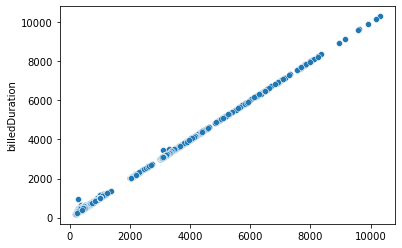

In [25]:
sns.scatterplot(data=df, x=df["endTimestamp"]-df["startTimestamp"], y="billedDuration")

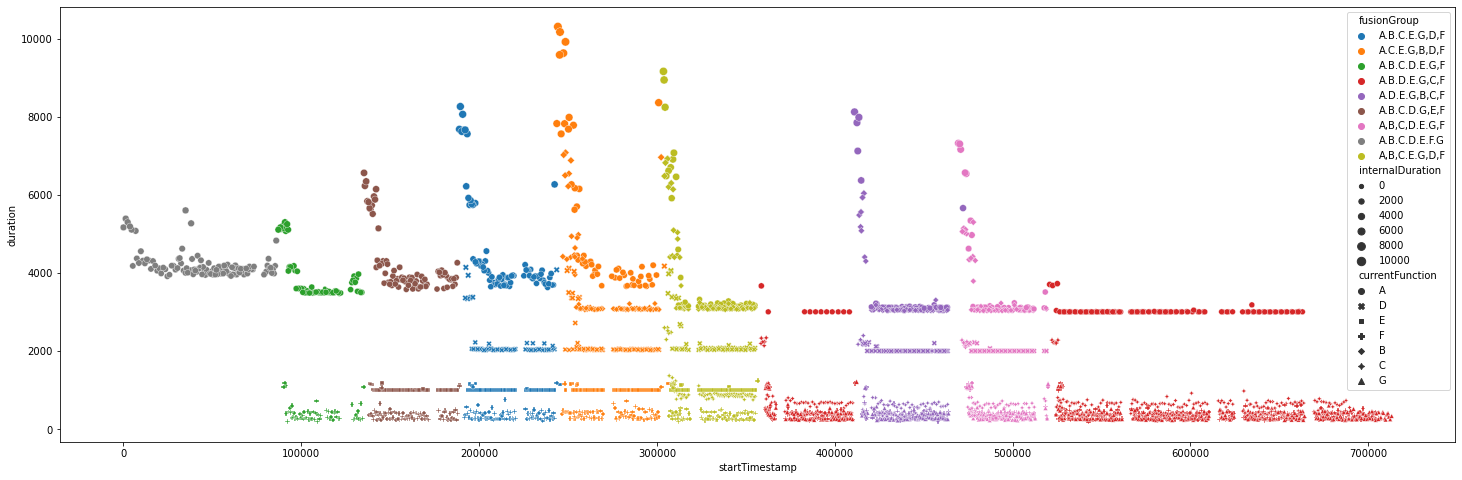

In [26]:
plt.figure(figsize=(25,8))
sns.scatterplot(data=df, x="startTimestamp", y="duration", size="internalDuration", hue=df["fusionGroup"], style="currentFunction")
plt.savefig("pointCloud.pdf")

<AxesSubplot:xlabel='startTimestamp', ylabel='10s_billedDuration_avg'>

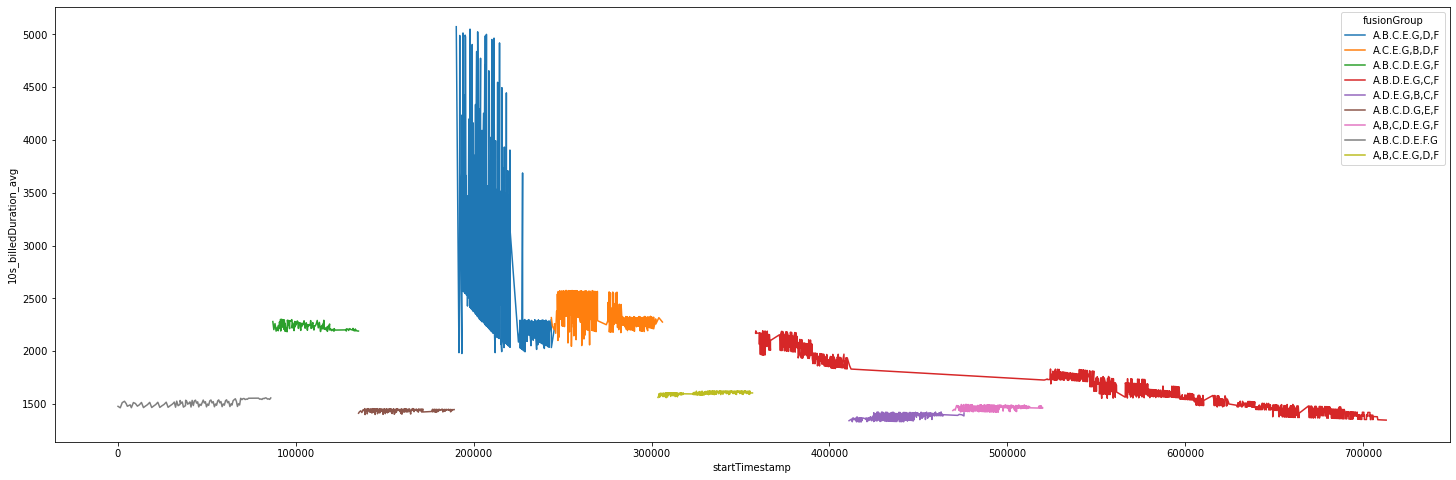

In [27]:
plt.figure(figsize=(25,8))
df['10s_billedDuration_avg'] = df['billedDuration'].rolling(10000, min_periods=30).mean()
#df['10s_billedDuration_med'] = df['billedDuration'].rolling(10000, min_periods=30).median()
sns.lineplot(data=df, x="startTimestamp", y="10s_billedDuration_avg", hue=df["fusionGroup"])
#sns.lineplot(data=df, x="startTimestamp", y="10s_billedDuration_med", hue=df["fusionGroup"])
#sns.scatterplot(data=df, x="startTimestamp", y="billedDuration", hue=df["fusionGroup"], legend=None)

In [28]:
# Now do not count every invocation, but sort the df by the cost of trace
grouped = df.groupby('traceId').agg({'billedDuration': ['sum'], 'startTimestamp': ['min'], 'endTimestamp': ['max'], 'fusionGroup': 'min'})
#grouped['numInvocations'] = df.groupby('traceId').count()
grouped['numInvocations'] = df.groupby('traceId').size()
print(f'Total Number of Invocations should be: {grouped["numInvocations"].sum()} == {len(df.index)}')

# Grouped: Get Root Invocation of TraceId and get rootEndTimestamp
# Pandas join() oder merge() machen mit dem alten Dataframe. Merge ist einfacher
rootInvocations = df[df["isRootInvocation"]][["traceId", "endTimestamp"]].rename(columns={"endTimestamp": "rootEndTimestamp"})
grouped = pd.merge(grouped, rootInvocations, how="left", on="traceId")
grouped["rootDuration"] = grouped["rootEndTimestamp"] - grouped["startTimestamp", "min"]

grouped

Total Number of Invocations should be: 3554 == 3554


/tmp/ipykernel_9506/2807751757.py:10: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  grouped = pd.merge(grouped, rootInvocations, how="left", on="traceId")


,traceId,"(billedDuration, sum)","(startTimestamp, min)","(endTimestamp, max)","(fusionGroup, min)","(numInvocations, )",rootEndTimestamp,rootDuration
0,002be0425693546f5163d02a94eeb37de747574be2ed42...,10536,291552,295712,"A.C.E.G,B,D,F",5,295712.0,4160.0
1,00c4b1f6d0d59c8533511efa5af4e1074dc5b7673470e8...,7566,416819,421721,"A.D.E.G,B,C,F",5,NaN,NaN
2,00cbcd1c1301630bb7e2f165b0ea194d46b15faa8169e4...,4084,64063,68146,A.B.C.D.E.F.G,1,68146.0,4083.0
3,00ccf40c91537e06f9bc9550a8a314b5aba3a9fb9c2583...,9483,442055,445206,"A.D.E.G,B,C,F",6,445206.0,3151.0
4,0173f1a9910c5fe35b5cab0f7d9663ec1d8ba28706df02...,7695,142041,148186,"A.B.C.D.G,E,F",3,148186.0,6145.0
...,...,...,...,...,...,...,...,...
1001,feb694dbaf477f5bb4cdbb54afa6ab6c68f98ca8173603...,5140,157765,161633,"A.B.C.D.G,E,F",3,161633.0,3868.0
1002,fecf417bc5f0a1c60d0e40860ba088ef4355e39da51a95...,6315,88273,93442,"A.B.C.D.E.G,F",2,93442.0,5169.0
1003,ff2ffaa30031c989564853439490bef3b4a5db82c3c828...,9683,494000,497098,"A,B,C,D.E.G,F",6,497098.0,3098.0
1004,ff973ec9fdfc0bbc66df81072112c0ebebb80405abdb16...,6029,446525,449575,"A.D.E.G,B,C,F",5,NaN,NaN


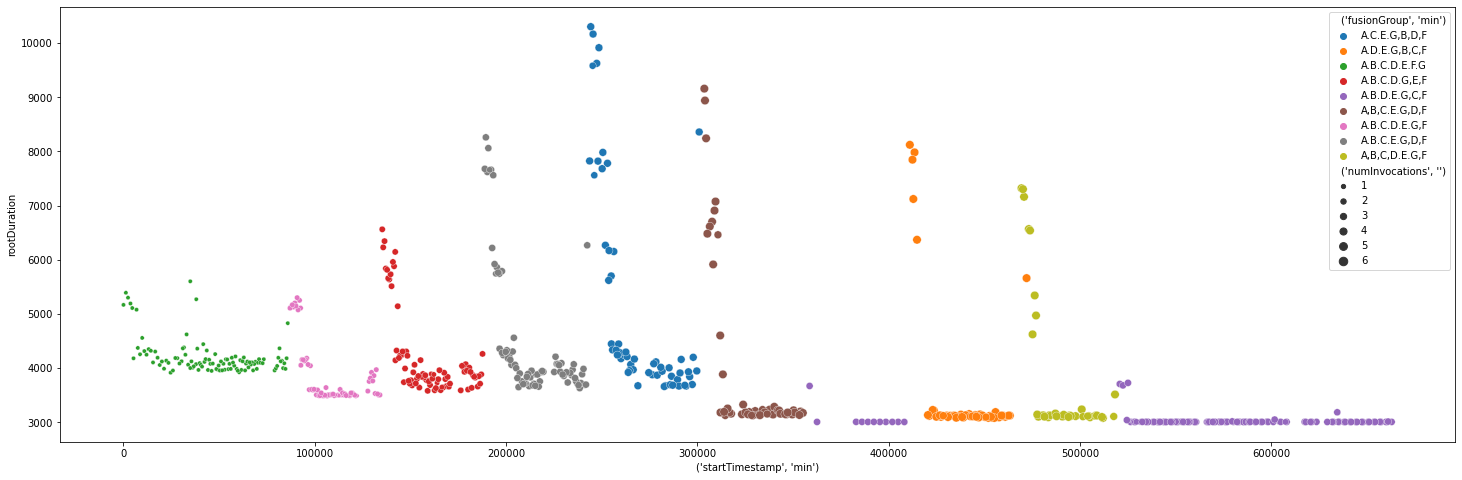

In [29]:
plt.figure(figsize=(25,8))
sns.scatterplot(data=grouped, x=grouped['startTimestamp', 'min'] , y=grouped['rootDuration'], hue=grouped['fusionGroup', 'min'], size=grouped["numInvocations", ""])
plt.savefig("duration.pdf")

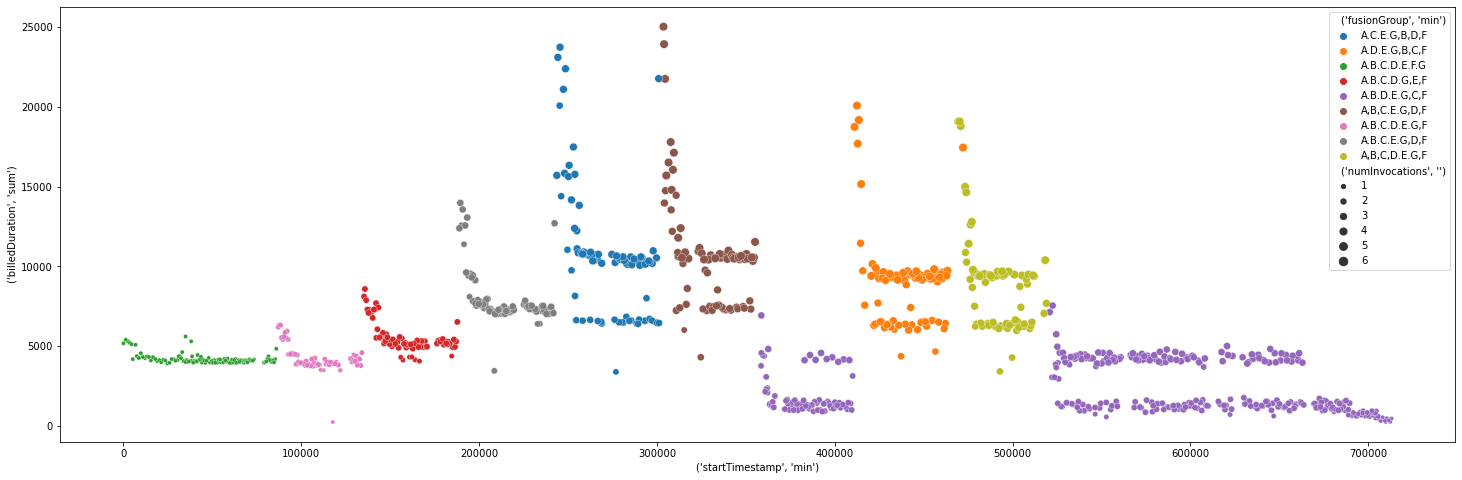

In [30]:
plt.figure(figsize=(25,8))
sns.scatterplot(data=grouped, x=grouped['startTimestamp', 'min'] , y=grouped['billedDuration', 'sum'], hue=grouped['fusionGroup', 'min'], size=grouped["numInvocations", ""])
plt.savefig("billed.pdf")